In [1]:
from Shared.shared import *
from Shared.specific_CNB_sim import *


sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
Delta_folder = f"Shared/Deltas"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)
perc_neutrinos_dec = np.load('sim_output/no_gravity_decay/decayed_neutrinos_perc.npy')

In [2]:
def number_density(p_init, p_back, pix_sr, args):
      
        """Neutrino number density obtained by integration over initial momenta.

        Args:
            p_init (array): neutrino momentum today
            p_back (array): neutrino momentum at z_back (final redshift in sim.)

        Returns:
            array: Value of relic neutrino number density in (1/cm^3).
        """    

        # note: trapz integral method needs sorted (ascending) "x-axis" array.
        ind = p_init.argsort(axis=-1)
        p_init_sort = jnp.take_along_axis(p_init, ind, axis=-1)
        p_back_sort = jnp.take_along_axis(p_back, ind, axis=-1)
        # shape should be (masses, npix, neutrinos per pixel)
      
        # Fermi-Dirac values with momenta at end of sim
        FD_arr = Physics.Fermi_Dirac(p_back_sort, args)
        
        # Calculate number density
        y = p_init_sort**3 * FD_arr  # dlog integrand
        x = p_init_sort

        n_raw = trap(y, jnp.log(x), axis=-1)

        # Multiply by constants and/or solid angles and convert to 1/cm**3.
        n_cm3 = pix_sr * args.g_nu/((2*args.Pi)**3) * n_raw / (1/args.cm**3)

        return jnp.array(n_cm3)
    

def number_densities_mass_range_decay(v_arr, m_arr, pix_sr, args):
        
        # Convert velocities to momenta.
        p_arr, _ = Physics.velocities_to_momenta(v_arr, m_arr, args)

        nu_dens = number_density(
            p_arr[...,0], p_arr[...,-1], pix_sr, args)

        return nu_dens
    

def velocities_to_momenta_all_sky(v_arr, m_arr, args):
        """
        Converts velocities to magnitude of momentum [eV] and ratio y=p/T_CNB, 
        according to desired target mass (and mass used in simulation). But now assuming the input array to have starting dimentions of (Npix, nu_per_pix), instead of just the total number of neutrinos (N,).
        """

        # Magnitudes of velocity.
        mags_arr = jnp.linalg.norm(v_arr, axis=-1)
        
        # From velocity (magnitude) in kpc/s to momentum in eV.
        p_dim = mags_arr[None,...]*(args.kpc/args.s) * m_arr[:,None,None,None]

        # p/T_CNB ratio.
        y = p_dim / args.T_CNB

        return p_dim, y
    

def number_densities_all_sky(v_arr, m_arr, pix_sr, args):

        # Convert velocities to momenta.
        p_arr, _ = velocities_to_momenta_all_sky(v_arr, m_arr, args)
        # (masses, Npix, neutrinos per pixel, 2 (first and last time step))
        
        # Compute number densities
        nu_dens = number_density(
            p_arr[..., 0], p_arr[..., -1], pix_sr, args)
        # (masses, Npix)

        return nu_dens

In [3]:
m_light, m_mid, m_heavy = Physics.neutrino_masses(
    m_lightest=0.1*Params.eV, ordering="NO", args=Params())

In [4]:
nu_m_picks_parent =np.array([m_heavy])
nu_m_picks_daughter =np.array([m_light])

gamma_str = [ "0.1T", "0.5T",
    "1T", "1.5T", "2T"]

In [5]:
# Choose which halo to plot

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"sim_output/no_gravity/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")

halos =['halo1','halo2','halo3','halo4','halo5','halo6','halo7','halo8','halo9','halo10']
all_number_density_parents_pix = []
all_number_density_daughters_pix = []
all_number_density_nodecay_pix = []
gamma_str = [ "0.1T", "0.5T",
    "1T", "1.5T", "2T"]
for halo in halos:
    number_density_all_sky_parent_arr  = []
    number_density_all_sky_daughter_arr =[]
    number_density_all_sky_nodecay_arr =[]
    for i, gamma in enumerate(gamma_str):
        nu_vectors = np.load(f'sim_output/{sim_name}/vectors_{halo}.npy')
        perc = perc_neutrinos_dec[i]/100

        number_density_all_sky_parent= number_densities_all_sky(
            v_arr=nu_vectors[..., 3:],
            m_arr=nu_m_picks_parent,
            pix_sr=simdata.pix_sr,
            args=Params())
        
        number_density_all_sky_daughter= number_densities_all_sky(
            v_arr=nu_vectors[..., 3:],
            m_arr=nu_m_picks_daughter,
            pix_sr=simdata.pix_sr,
            args=Params())


       
        
       # number_density_all_sky_parent_arr.append(number_density_all_sky_parent.reshape(768) - perc*number_density_all_sky_parent.reshape(768))
       #number_density_all_sky_daughter_arr.append(perc*number_density_all_sky_daughter.reshape(768))

        number_density_all_sky_parent_arr.append(number_density_all_sky_parent - perc*number_density_all_sky_parent)
        number_density_all_sky_daughter_arr.append(perc*number_density_all_sky_daughter)
        number_density_all_sky_nodecay_arr.append(number_density_all_sky_parent)
      

        
    all_number_density_nodecay_pix.append(number_density_all_sky_nodecay_arr)
    all_number_density_parents_pix.append(number_density_all_sky_parent_arr)
    all_number_density_daughters_pix.append(number_density_all_sky_daughter_arr)

In [6]:
def power_spectra_FDxPF_decay(
    m_pick, pix_dens_FD, y_lims, sim_dir, fig_dir, gamma, args):
    
    m_specs = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*args.eV
    m_range = jnp.load(f"{sim_dir}/neutrino_massrange_eV.npy")

    mPF_i = jnp.abs(m_specs - m_pick).argmin()
    # mFD_i = jnp.abs(m_range - m_pick).argmin()
    mFD_i = jnp.abs(m_specs - m_pick).argmin()

    halo_num = len(pix_dens_FD)

    power_spectra_FD_l = []
    for halo_i in range(halo_num):

        m_nu = m_specs[mFD_i]

        FD_skymap = pix_dens_FD[halo_i, mFD_i]

        # Convert maps of neutrino densities to temperatures.
        cm3 = args.cm**3
        FD_Tmap = np.cbrt((FD_skymap*(1/cm3)*4*args.Pi**2) / (args.g_nu*3*zeta(3)))

        T_unit = args.muK
        FD_Tmap /= T_unit

        # Compute power spectrum of number density all-sky map.
        cl_FD = hp.sphtfunc.anafast(FD_Tmap, lmax=None)

        ell = jnp.arange(len(cl_FD))

        # Unit to compare to similar figures in literature.
        # scaling = Primordial.Cl_scaling
        scaling = 1  # if Tmaps already in muK
        
        power_spectrum_FD = ell * (ell+1) * cl_FD * scaling / (2*args.Pi)

        power_spectra_FD_l.append(power_spectrum_FD)


    # Convert lists to arrays
    power_spectra_FD = jnp.array(power_spectra_FD_l)

    # Compute median and percentile ranges for Fermi-Dirac spectra
    power_median_FD = jnp.median(power_spectra_FD, axis=0)
    power_perc2p5_FD = jnp.percentile(power_spectra_FD, q=2.5, axis=0)
    power_perc97p5_FD = jnp.percentile(power_spectra_FD, q=97.5, axis=0)
    power_perc16_FD = jnp.percentile(power_spectra_FD, q=16, axis=0)
    power_perc84_FD = jnp.percentile(power_spectra_FD, q=84, axis=0)

    fig = plt.figure(figsize =(6, 4))
    fig.tight_layout()
    ax1 = fig.add_subplot(111)

    FD_color = "mediumblue"
    ax1.semilogy(
        ell, power_median_FD, color=FD_color, 
        label=r"$f_{\rm FD}$")
    ax1.fill_between(
         ell, power_perc2p5_FD, power_perc97p5_FD, 
         color=FD_color, alpha=0.15, label='2.5-97.5 % C.L.')
    ax1.fill_between(
        ell, power_perc16_FD, power_perc84_FD, 
        color=FD_color, alpha=0.25, label='16-84 % C.L.')
    

    # ax1.set_title(fr"Power spectra comparison $m_\nu = ${m_pick} eV")
    ax1.set_xlabel("$\ell$")
    # ax1.set_xlim(1,np.max(ell))
    ax1.set_xlim(1,21)
    ax1.set_ylabel(r"$\ell(\ell+1)C_{\ell} \, / \, 2\pi \,\, [\mu K^2]$")

    if y_lims is not None:
        ax1.set_ylim(y_lims[0], y_lims[1])

    ax1.grid(True, which="major", linestyle="dashed")
    ax1.legend(loc='lower left', prop={'size':10})
    '''
    plt.savefig(
        f"{fig_dir}/parents/power_spectra_FD_vs_PF_decay_{gamma}_{m_pick}eV.pdf", 

        
    plt.savefig(
        f"{fig_dir}/parents/power_spectra_FD_vs_PF_decay_{gamma}_{m_pick}eV.png", 
        bbox_inches="tight")'''
    plt.show(); plt.close()

In [7]:
N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)
#daughters:
ymin =1e5
ymax =1e12
m_pick = m_light
pix_dens_FD =np.array(all_number_density_daughters_pix)

#parents:
'''ymin= 1e2
    ymax=1e9
    m_pick = m_heavy
    pix_dens_FD =np.array(all_number_density_parents_pix)'''

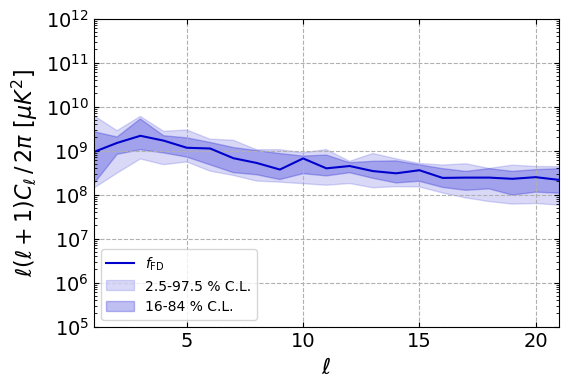

In [8]:
fig_folder = f"figures_local/{sim_name}/"
power_spectra_FDxPF_decay(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD[:,0,:,:] - skymap_norm, 
        # y_lims=None,
        y_lims=(ymin,ymax),
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        gamma = gamma_str[i],
        args=Params())

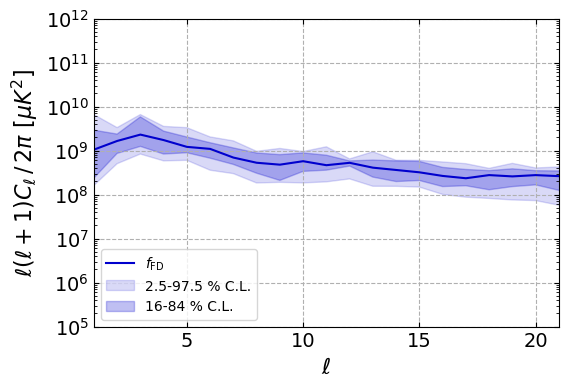

In [9]:

power_spectra_FDxPF_decay(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD[:,1,:,:] - skymap_norm, 
       #  y_lims=None,
        y_lims=(ymin,ymax),
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        gamma = gamma_str[i],
        args=Params())

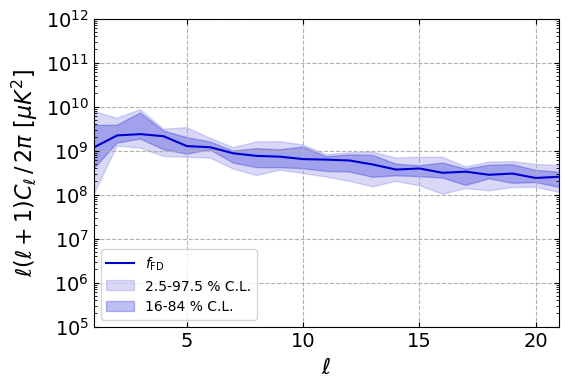

In [10]:

power_spectra_FDxPF_decay(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD[:,2,:,:] - skymap_norm, 
        # y_lims=None,
        y_lims=(ymin,ymax),
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        gamma = gamma_str[i],
        args=Params())

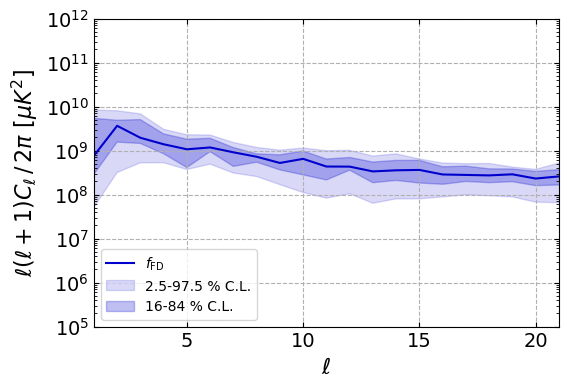

In [11]:

power_spectra_FDxPF_decay(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD[:,3,:,:] - skymap_norm, 
        # y_lims=None,
        y_lims=(ymin,ymax),
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        gamma = gamma_str[i],
        args=Params())

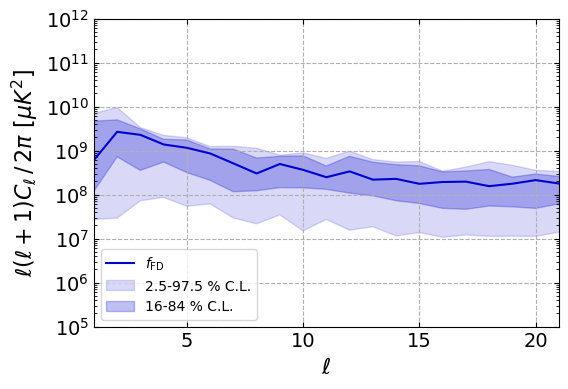

In [12]:
fig_folder = f"figures_local/{sim_name}/"
power_spectra_FDxPF_decay(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD[:,4,:,:] - skymap_norm, 
        # y_lims=None,
        y_lims=(ymin,ymax),
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        gamma = gamma_str[i],
        args=Params())